Kaggle Titanic Dataset Competition
----
Let's import the necessary libraries, then start some exploratory analysis.

In [110]:
from collections import Counter, defaultdict
from functools import partial
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser
import functools
import pandas as pd
import numpy as np
import seaborn as sns

Let's load in the initial data.
----

In [111]:
data = pd.read_csv("datasets/titanic_train.csv")  # Reading in the data
tgt  = data["Survived"]                           # Retain a copy of the target variable
#data = data.drop(["Survived"], axis=1)            # Remove the target value from the dataset.
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [112]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Next, let's checkout the cleanliness of our dataset.
----

In [113]:
nullity = pd.isnull(data).any(axis=0)
print(nullity)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool


Null value discussion
----
So from calling isnull on the pandas dataframe containing the dataset, we've been able to figure out which columns include null values, or "None", and need to be cleaned. We can see that there are three different variables containing missing values:

- $\textbf{Age}$: Purely quantitative variable representing the subject's age. In order to fill null age data, you could utilize the mean age of all passengers aboard the Titanic. This way, we're not adding too much new information with unnecessarily drawn conclusions about age from other variables. We leave this at the mean to smooth out the noise that a zero, or null, value causes.


- $\textbf{Cabin}$: Qualitative variable representing the cabin number. If you take a look back at the summary of the data, you will see entries like "C85" and "C123". In order to solve the nullity issue with this variable, you could either choose to remove the variable's data from the dataset altogether, or essentially make not having a room a feature in your dataset, which is a move that could add unecessary bias. Right after this, we'll look a little more into Cabin.


- $\textbf{Embarked}$: Qualitative variable representing the location of embarkation of the subject.


Let's tackle Age first.
----

In [114]:
age_mean = data["Age"].dropna().mean() # Accesses "Age", removes the None values, and calculates the mean.
data["Age"] = data["Age"].fillna(age_mean)
        
print("The Mean Age is: " + str(age_mean))
print("Variable nullity: " + str(pd.isnull(data["Age"]).any()))

The Mean Age is: 29.6991176471
Variable nullity: False


Whew! Alright, not too bad. We've effectively replaced all "None" values in the "Age" variable with the mean, and have solved one of our three null value issues.

After that, let's assess Cabin.
----
Before we decide if we want to chuck the entire variable, let's see how big of an issue the nullity is.

In [115]:
cabin_nullity = data["Cabin"].isnull().sum()
cabin_size    = len(data["Cabin"])

print("The number of None Cabin records: " + str(cabin_nullity))
print("The total number of records: " + str(cabin_size))
print("Proportion missing: " + str(float(cabin_nullity)/float(cabin_size)*100))

The number of None Cabin records: 687
The total number of records: 891
Proportion missing: 77.1043771044


Yikes.
----
Keeping in mind that almost 80% of the Cabin data is missing, let's just completely throw that variable out.

In [116]:
data = data.drop(["Cabin"], axis = 1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Finally, let's approach Embarked.
----
Like Cabin, let's check out what proportion of the data has a missing Embarked value.

In [117]:
embarked_nullity = data["Embarked"].isnull().sum()
embarked_size    = len(data["Embarked"])

print("The number of None Cabin records: " + str(embarked_nullity))
print("The total number of records: " + str(embarked_size))
print("Proportion missing: " + str(float(embarked_nullity)/float(embarked_size)*100))

The number of None Cabin records: 2
The total number of records: 891
Proportion missing: 0.224466891134


In this case, very few are missing Embarked.
---
Because of this, instead of removing this variable, a valid next step would be to either place a random value from the rest of the embarkation location encodings for the two missing subjects, or you could simply remove those subjects from the dataset. Let's look a little closer, and actually extract the records of the passengers of unknown origin.

In [118]:
embarked = data["Embarked"].values

missing = []
for x in range(len(embarked)):
    if str(embarked[x]) == "nan":
        missing.append(x)
        
for x in missing:
    print("Missing subject:")
    print(data.ix[x])
    print("\n")
    
print("Average fare: " + str(data["Fare"].mean()))

Missing subject:
PassengerId                     62
Survived                         1
Pclass                           1
Name           Icard, Miss. Amelie
Sex                         female
Age                             38
SibSp                            0
Parch                            0
Ticket                      113572
Fare                            80
Embarked                       NaN
Name: 61, dtype: object


Missing subject:
PassengerId                                          830
Survived                                               1
Pclass                                                 1
Name           Stone, Mrs. George Nelson (Martha Evelyn)
Sex                                               female
Age                                                   62
SibSp                                                  0
Parch                                                  0
Ticket                                            113572
Fare                                      

E:\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


Aha!
----
Two older ladies travelling together with a ticket costing approximately twice the average fare (before cleaning), which would follow that they'd be normal passengers and not significant outliers in any way except higher than average ages. To avoid adding bias into the dataset by making assumptions and drawing conclusions based upon incomplete data, I'm chosing to remove the records that are missing their Embarked value.

In [119]:
# Drop the rows/passengers with missing Embark data.
for loc in missing:
    data = data.drop(loc)

And...
---

In [120]:
nullity = pd.isnull(data).any(axis=0)
print(nullity)

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Embarked       False
dtype: bool


Woop! We've taken care of all of the null values!
----
Let's take this opportunity to make a clean backup of our data.

In [121]:
clean_data = data
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Next, it's time to understand our quantitative variables a little better.
----
Let's start by visualizing:

- Pclass: Ticket Class
- Age: Age in Years
- SibSp: Number of siblings/spouses aboard
- Parch: Number of parents/children aboard
- Fare: Passenger fare

Histogram binning of Qualitiative Variables.
----

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000299A00F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000027E369B0>]], dtype=object)

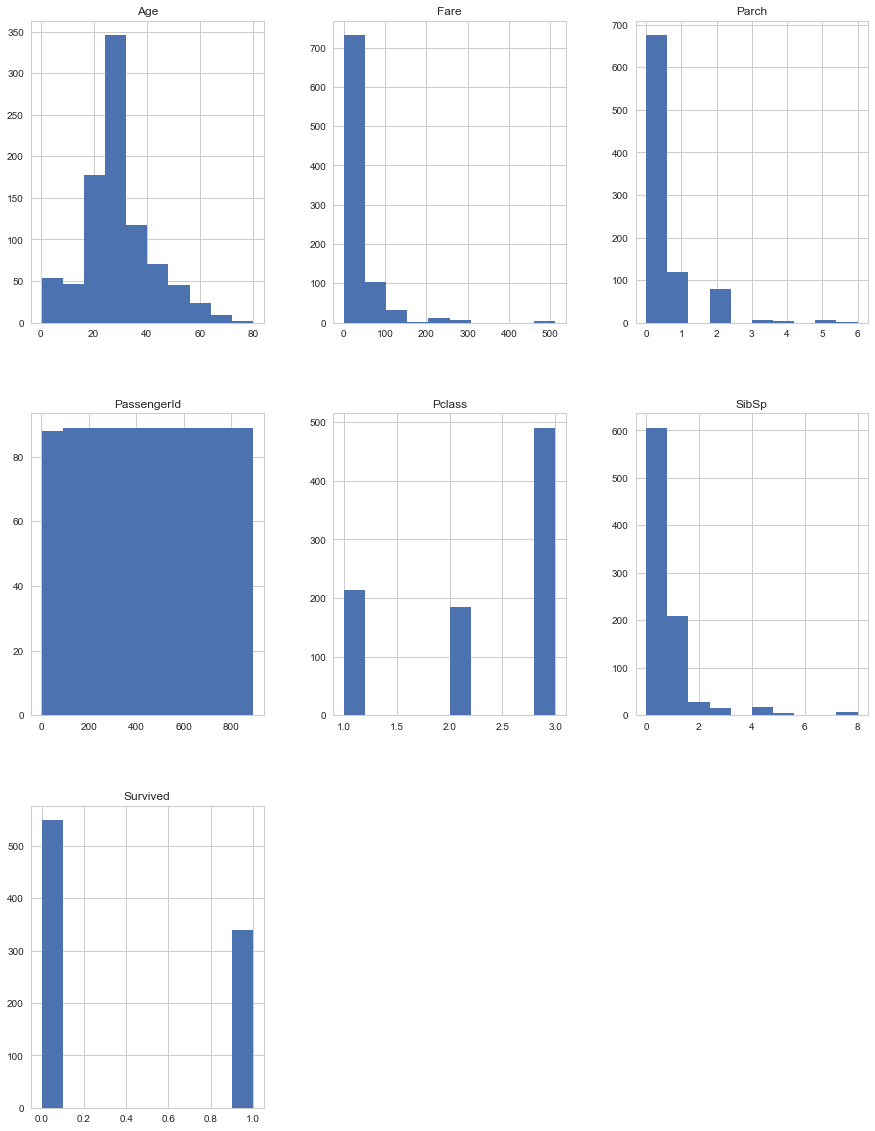

In [122]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)

Let's talk about each individually, starting with Age
---
If you look at the Age data, you can see that it behaves pretty much like you'd expect. A large number of people aged 20-30, with the age representation tapering to approximately 80 years old at the eldest passenger, which, again is as expected. There's nothing out of the ordinary about Age now that it's had its Null values replaced with the mean.

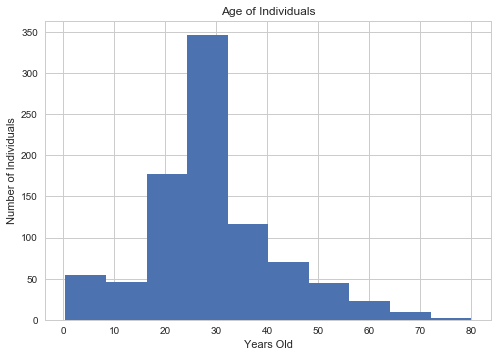

In [123]:
data["Age"].hist()
plt.title("Age of Individuals")
plt.ylabel("Number of Individuals")
plt.xlabel("Years Old")

Fare
----
The data in fair also look about like what you'd expect, with the potential of a few outliers. If you see, there are a few tickets that are a lot more expensive than the rest, ballpark 500 pounds. Let's check out those profiles and see if there's anything weird about them.

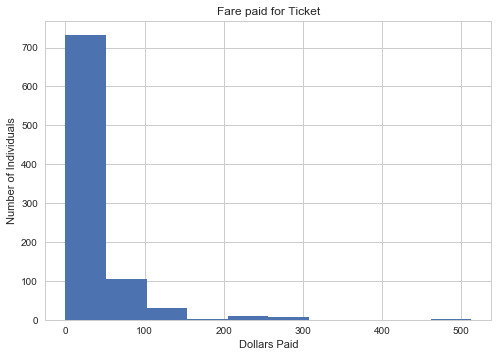

In [124]:
data["Fare"].hist() 
plt.title("Fare paid for Ticket")
plt.ylabel("Number of Individuals")
plt.xlabel("Dollars Paid")

Fare Insight
----
From looking at the outlier grouping, we can actually see that all three of these individuals were on the same ticket, and paid the exact same amount. This leads me to believe that this potentially may be the structure of the data, and as such we'll be able to get a deeper understanding of the social network of the passengers on board. I would also conclude that there's nothing out of the ordinary about the price; Three first class tickets for a middle aged (for the time) group of individuals who could've paid for large amounts of luggage to be shipped. I also confirmed the price of the ticket by doing some research online into Titanic survivors.

A good to-do from this is encoding ticket IDs into cluster IDs.

In [125]:
fare_outliers = [x for x in data["Fare"] if x > 300]
print("Outlier values: " + str(fare_outliers))

for index, row in data.iterrows():
    if row['Fare'] > 300:
        print("")
        print row

Outlier values: [512.32920000000001, 512.32920000000001, 512.32920000000001]

PassengerId                 259
Survived                      1
Pclass                        1
Name           Ward, Miss. Anna
Sex                      female
Age                          35
SibSp                         0
Parch                         0
Ticket                 PC 17755
Fare                    512.329
Embarked                      C
Name: 258, dtype: object

PassengerId                                   680
Survived                                        1
Pclass                                          1
Name           Cardeza, Mr. Thomas Drake Martinez
Sex                                          male
Age                                            36
SibSp                                           0
Parch                                           1
Ticket                                   PC 17755
Fare                                      512.329
Embarked                                    

Parch
----
Let's check out how the data for parents and children. From looking at this histogram, you can see that the majority of the passengers were on the boat alone, and comparatively few actually had others that they were travelling with. Especially in a survival situation, having more people to take care of could be the difference between survival and not making it.

Let's look at the representation of passengers with and without accompaniment.

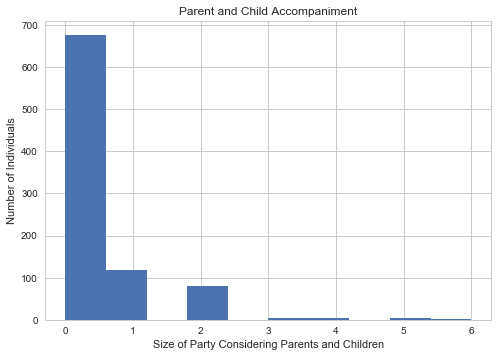

In [126]:
data["Parch"].hist()    
plt.title("Parent and Child Accompaniment")
plt.ylabel("Number of Individuals")
plt.xlabel("Size of Party Considering Parents and Children")

In [127]:
alone  = float(len([x for x in data["Parch"] if x == 0]))
friend = float(len([x for x in data["Parch"] if x > 0]))
both   = alone + friend

print("Proportion travelling alone: " + str((alone/both)*100))
print("Proportion travelling with accompaniment: " + str((friend/both)*100))
print("Most common overall Parch value: " + str(data["Parch"].mean()))

# Let's check out the mean value of those with accompaniment
accompanied = [x for x in data["Parch"] if x > 0]
print("Most common accompanied Parch value: " + str(float(sum(accompanied))/float(len(accompanied))))

Proportion travelling alone: 76.0404949381
Proportion travelling with accompaniment: 23.9595050619
Most common overall Parch value: 0.382452193476
Most common accompanied Parch value: 1.59624413146


SibSp
---
For the sibling/spousal variable, let's do the exact same thing.

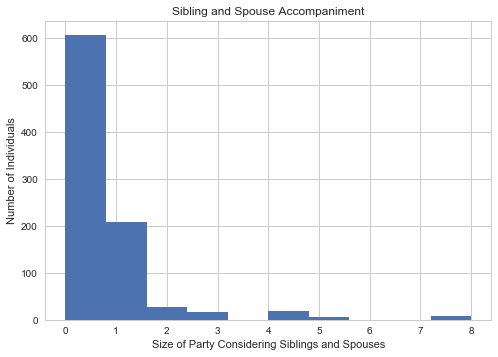

In [128]:
data["SibSp"].hist()
plt.title("Sibling and Spouse Accompaniment")
plt.ylabel("Number of Individuals")
plt.xlabel("Size of Party Considering Siblings and Spouses")

In [129]:
alone  = float(len([x for x in data["SibSp"] if x == 0]))
friend = float(len([x for x in data["SibSp"] if x > 0]))
both   = alone + friend

print("Proportion travelling alone: " + str((alone/both)*100))
print("Proportion travelling with accompaniment: " + str((friend/both)*100))
print("Most common overall SibSp value: " + str(data["SibSp"].mean()))

# Let's check out the mean value of those with accompaniment
accompanied = [x for x in data["SibSp"] if x > 0]
print("Most common accompanied SibSp value: " + str(float(sum(accompanied))/float(len(accompanied))))

Proportion travelling alone: 68.1664791901
Proportion travelling with accompaniment: 31.8335208099
Most common overall SibSp value: 0.52418447694
Most common accompanied SibSp value: 1.64664310954


Let's see how the dispersion of total party size looks
---
Because SibSp and Parch are both quantities of people the individual is travelling with, let's check out the full party size for each person.

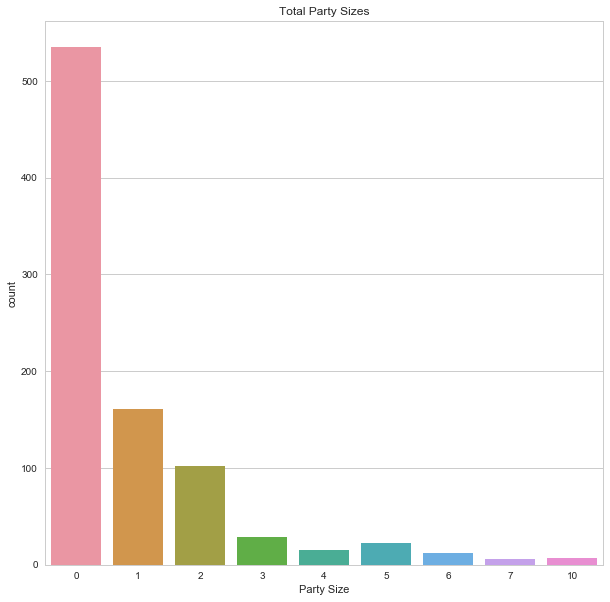

In [130]:
parch = data["Parch"]
sibsp = data["SibSp"]

party = parch + sibsp

data.insert(loc = 9, column="Party Size", value = party)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

sns.countplot(x = "Party Size", data=data, linewidth=2, ax=ax)
plt.title("Total Party Sizes")
plt.show()

PClass
----
Luckily, PClass is simply 1, 2 or 3. It doesn't look like it behaves irregularly. The only issue may be in that PClass is inherently given a negative connotation due to the hierarchy of the values; 3 could be deemed above 1 and 2, though logically we know that in our culture, "First Class" is the best, and this is also reflected by the sparsity of first class tickets held with the sparsity of higher priced tickets.

Mostly a mental note.

Now that we've got a better understanding of the variables as they exist independently, let's continue on to look at correlation, covariance, and multivariate summaries of the data.

Graphical Correlation Matrix
----
Source: https://seaborn.pydata.org/generated/seaborn.pairplot.html

If you look to the right of the Correlation Matrix, you'll see the key. Blue has been attributed to non-survival, and Green has been attributed to those passengers that survived.

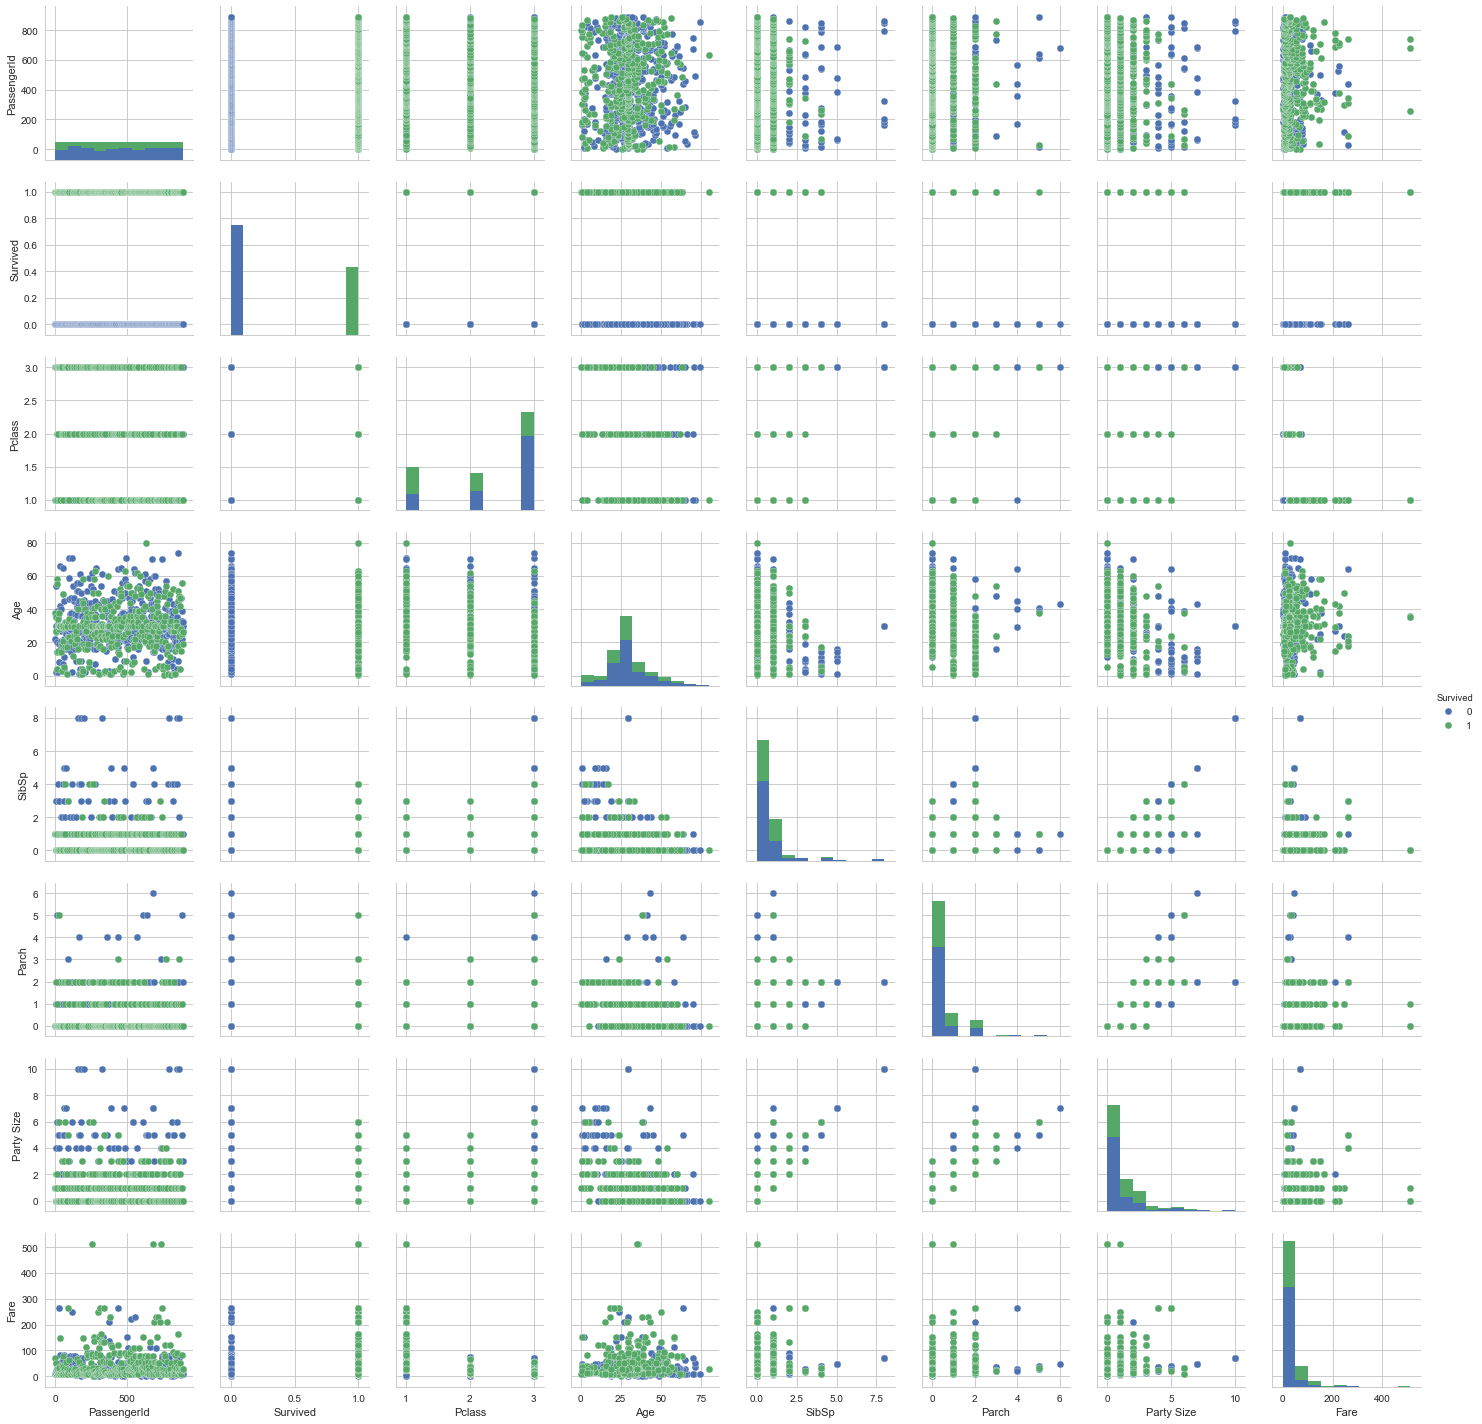

In [131]:
sns.pairplot(data, hue="Survived")

Quantitative Correlation Matrix
----

In [132]:
a = data.corr() # Keeps from transforming the dataset into NDarray
a

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Party Size,Fare
PassengerId,1.000000,-0.005028,-0.035330,0.030300,-0.057686,-0.001657,-0.040258,0.012703
Survived,-0.005028,1.000000,-0.335549,-0.074673,-0.034040,0.083151,0.018277,0.255290
Pclass,-0.035330,-0.335549,1.000000,-0.327954,0.081656,0.016824,0.064221,-0.548193
Age,0.030300,-0.074673,-0.327954,1.000000,-0.231875,-0.178232,-0.247546,0.088604
SibSp,-0.057686,-0.034040,0.081656,-0.231875,1.000000,0.414542,0.890654,0.160887
Parch,-0.001657,0.083151,0.016824,-0.178232,0.414542,1.000000,0.782988,0.217532
Party Size,-0.040258,0.018277,0.064221,-0.247546,0.890654,0.782988,1.000000,0.218658
Fare,0.012703,0.255290,-0.548193,0.088604,0.160887,0.217532,0.218658,1.000000


Let's zoom into some of the more interesting correlations. Time for handwaving!
----

Survival, Pclass and Fare:
---
If you look at the quantitative correlation matrix, you'll see that Fare and Pclass have an anti-correlation of -0.54 on a [-1, 1] scale. Weird! Why would that be? Let's think back to the encoding of Pclass we talked about. The best, most optimal class, on the Titanic was first class. Following that, second class is middle however you run the numbers, but third class is the worst. If you think in terms of linear progression, as the value of class increases, the average cost of the fare decreases.

Now, you may be asking yourself, how does this tie back into Survival, and why is it important? Well, if you look at Survived and Pclass, there's an anti-correlation of -0.33! Keeping in mind that Fare and Pclass have an anti correlation as well, it can be concluded that there is a positive correlation with class and survival of 0.33, if you consider that "First class" should actually be ranked highest.

This is an important insight to check out during PCA; How well does the PClass variable explain the survivability outcome of this passenger? If what we've learned holds true, because Pclass (and thus further, Fare) have the highest correlation with survival, those variables should have high Principle Component 1 coefficients.

Age, Pclass and Fare:
---
Pclass and Age have an anti-correlation of -0.32, which indicates that older passengers were likelier to be either middle or first class passengers. Following that, age has a slightly negative correlation with survival. What can be inferred is that there were few enough wealthy passengers that were older to essentially disregard out the high correlation of age with class.

My assertion is that no matter if you were higher class, if you were older, you likely parished. On the other hand, if you were simultaneously younger and higher class (i.e., wealthier), you had a much higher chance of surviving the Titanic.

Age, SibSp and Parch:
---
Both SibSp and Parch have a negative correlation with age, which indicates that older passengers were more likely to be travelling by themselves, and that there were more, younger families. This is reinforced by Sibling/Spouse and Parent/Children having a correlation of 0.41, meaning that if you have a sibling or spouse with you, you were likely to also have either your parents, or your children.

Interestingly, Parents/Children has a .08 positive correlation with survivability, and spouse/sibling has a -.03 correlation with survivability. This would allude to there being little to no correlation with travelling with someone and surviving, except for potentially those who had children may have been more likely to be saved, though they were mostly trying to fill the lifeboats.

To tie in Fare, Parch and SibSp have little to no correlation with PClass, but they do have a correlation with Fare, which would indicate an obvious fact, that it was more expensive to travel with others than alone regardless of the type of class ticket you have.

To sum it up:
---
The data tell a pretty well defined story, though hold a lot of noise, obviously due to the fact that the Titanic was a disaster situation. These clusters of correlations could be transformed into features.

Qualitative Variable Exploration
----

Let's look into the structure of the shared tickets
---
Earlier, we said that there may be some structure to the shared tickets. Let's check out how SibSp, Parch, and Ticket all tie in together by visualizing the passengers that shared tickets alongside those who came alone.

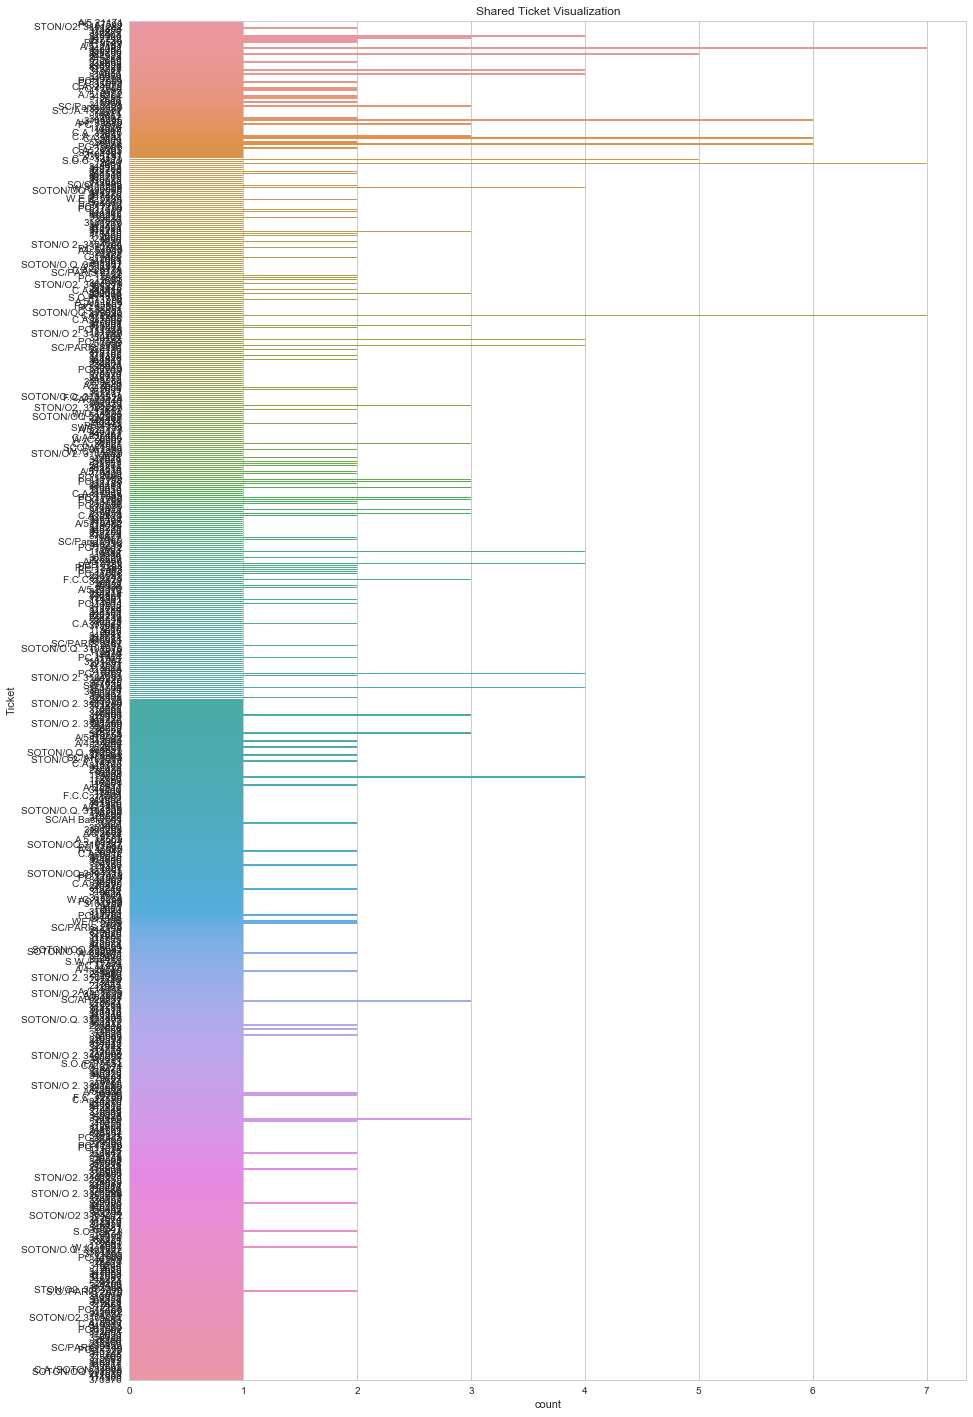

In [133]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.figure(figsize = (15,25))
ax = fig.gca()

sns.countplot(y="Ticket", data=data, linewidth=.5, ax=ax)
plt.title("Shared Ticket Visualization")
plt.show()

Let's check out how those tickets look individually.
---
As you can see from the visualization, some of the ticket strings are longer than others, but there is a consistent pattern. Here's the first 25 tickets of the dataset:

In [134]:
print(data["Ticket"][:25])

0            A/5 21171
1             PC 17599
2     STON/O2. 3101282
3               113803
4               373450
5               330877
6                17463
7               349909
8               347742
9               237736
10             PP 9549
11              113783
12           A/5. 2151
13              347082
14              350406
15              248706
16              382652
17              244373
18              345763
19                2649
20              239865
21              248698
22              330923
23              113788
24              349909
Name: Ticket, dtype: object


Let's get into some text mining, shall we?
----
Looking through the data for Ticket, I notice there's a pretty strong pattern of either having just a number, or having some type of prefix to that number. In order to try and really zoom in on the information these data hold, let's parse Ticket with regular expressions, splitting Ticket into Prefix and ID.

In [135]:
import re
#data = data.drop("ID", axis=1)

# Prefix scraper
ticket_reg = '\w+\/\w+\.?|\w+ |\w+\.\/?\w+\.\/?\w?\.?\w?\.?|\w+\. '

tickets = data["Ticket"]

prefix = []
ID     = []
for ticket in tickets:
    matches = re.findall(ticket_reg, ticket)
    if len(matches) == 0:
        if ticket == "LINE":
            prefix.append("LINE")
            ID.append(int(0))
        else:
            prefix.append("None")
            ID.append(int(ticket))
    else:
        prefix.append(matches[0])
        ID.append(int(ticket.split(" ")[-1]))

data = data.drop("Ticket", axis=1)
data.insert(loc = 0, column="Prefix", value = prefix)
data.insert(loc = 0, column="Ticket", value = ID)

data.head()

,Ticket,Prefix,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Party Size,Fare,Embarked
0,21171,A/5,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,1,7.2500,S
1,17599,PC,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,1,71.2833,C
2,3101282,STON/O2.,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,0,7.9250,S
3,113803,None,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,1,53.1000,S
4,373450,None,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,0,8.0500,S


Now, let's check out Embarkation Location
----
The location of embarkation is encoded into:

- S: South Hampton

- C: Cherbourg

- Q: Queenstown

Logically, this could be transformed into 0 for South Hampton, 1 for Cherbourg, and 2 for Queenstown in order of rarity to transition the location of embarkation into a numeric feature.

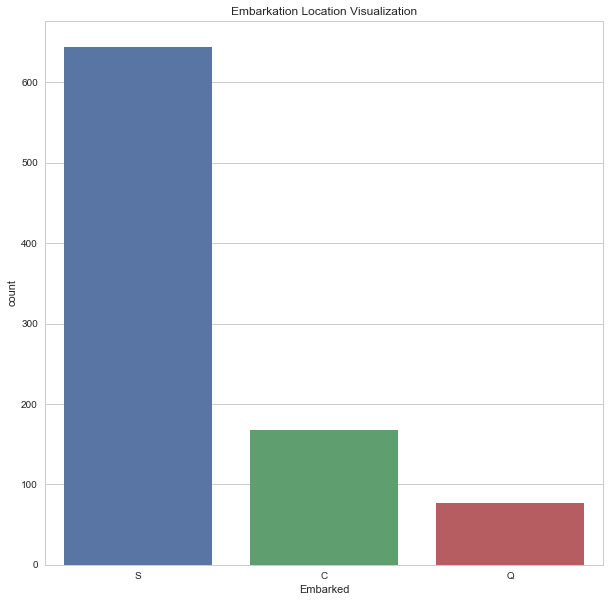

In [136]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

sns.countplot(x="Embarked", data=data, linewidth=2, ax=ax)
plt.title("Embarkation Location Visualization")
plt.show()

In [154]:
loc = data["Embarked"]
embarked_int = []
for place in loc:
    if place == "S":
        embarked_int.append(0)
    elif place == "C":
        embarked_int.append(1)
    elif place == "Q":
        embarked_int.append(2)
        
# Replace the String Embarked with the Int Embarked.
data = data.drop("Embarked", axis=1)
data.insert(loc = 10, column="Embarked", value = embarked_int)
data.head()

,Ticket,Prefix,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Embarked,Title,Alone,Miss,Mrs,Mr,Master,Important,Party Size,Fare
0,21171,A/5,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,0,Mr,0,0.0,0.0,1.0,0.0,0.0,1,7.2500
1,17599,PC,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,1,Mrs,0,0.0,1.0,0.0,0.0,0.0,1,71.2833
2,3101282,STON/O2.,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,0,Miss,1,1.0,0.0,0.0,0.0,0.0,0,7.9250
3,113803,None,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,0,Mrs,0,0.0,1.0,0.0,0.0,0.0,1,53.1000
4,373450,None,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,0,Mr,1,0.0,0.0,1.0,0.0,0.0,0,8.0500


Now it's time to text mine "Name"!
---
The last variable for us to look at is the "Name" category. As it stands, these strings aren't structured enough to really tell us anything, but let's try and see what kind of information is to be found. Let's print the first 25 names.

In [137]:
print(data["Name"][:25])

0                               Braund, Mr. Owen Harris
1     Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                Heikkinen, Miss. Laina
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                              Allen, Mr. William Henry
5                                      Moran, Mr. James
6                               McCarthy, Mr. Timothy J
7                        Palsson, Master. Gosta Leonard
8     Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                   Nasser, Mrs. Nicholas (Adele Achem)
10                      Sandstrom, Miss. Marguerite Rut
11                             Bonnell, Miss. Elizabeth
12                       Saundercock, Mr. William Henry
13                          Andersson, Mr. Anders Johan
14                 Vestrom, Miss. Hulda Amanda Adolfina
15                     Hewlett, Mrs. (Mary D Kingcome) 
16                                 Rice, Master. Eugene
17                         Williams, Mr. Charles

Ah, some structure.
---
Looking at the data, it's clear that each and every person is given some sort of title:

- Mr.
- Mrs.
- Miss.
- Master.
- And I could only assume that there are others like "Sir" and "Madame".

Let's actually see if we can extract them all using regular expressions.

Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)


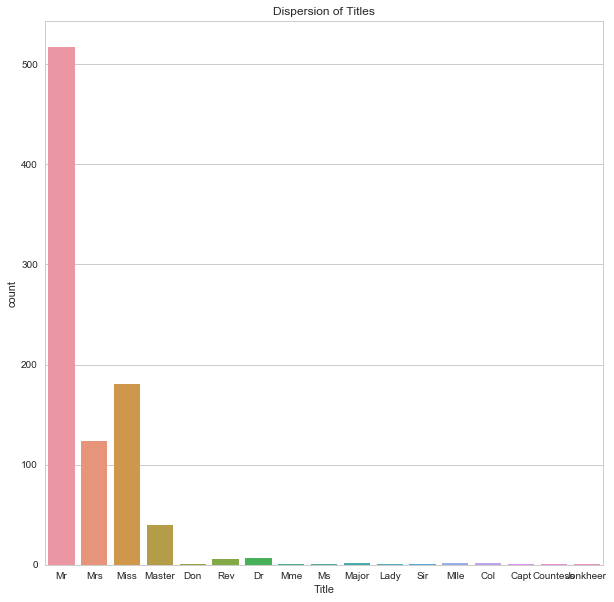

In [138]:
#data = data.drop("Title", axis=1)

title = ', (\w+)\.'
names = data["Name"]

titles = []
for name in names:
    matches = re.findall(title,name)
    if len(matches) == 0:
        print(name)
        titles.append("Countess")
    else:
        titles.append(matches[0])
    
data.insert(loc = 10, column="Title", value = titles)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

sns.countplot(x = "Title", data=data, linewidth=2, ax=ax)
plt.title("Dispersion of Titles")
plt.show()

We've found quite a few titles!
----
To make our data cleaner, let's cluster everyone who isn't "Mr", "Mrs", "Miss" or "Master" into "Important", and replot the dispersion. It looks much better.

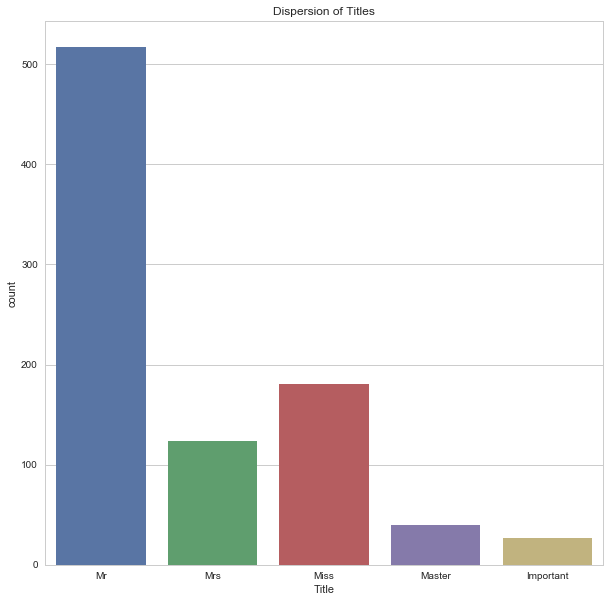

In [139]:
valid_titles = ["Mr", "Mrs", "Miss", "Master"]

for x in range(len(titles)):
    if titles[x] not in valid_titles:
        titles[x] = "Important" 
        
data["Title"] = titles        

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

fig = plt.figure(figsize = (10,10))
ax = fig.gca()

sns.countplot(x = "Title", data=data, linewidth=2, ax=ax)
plt.title("Dispersion of Titles")
plt.show()

Let's address the new variables we've created:
----
- Mr: Boolean from Title

- Mrs: Boolean from Title

- Miss: Boolean from Title

- Master: Boolean from Title

- Important: Boolean from Title

- Party Size: Total of SibSp and Parch for each individual

- Embarkation Site: 0, 1, or 2 based on rarity of that hub.

    - Could also carry into boolean variables for identity.
    
We could also tap into other things, like a boolean flag for the person travelling alone or with family.

Let's enter the "Alone" flag, and check to see if it correlates with Survival:
---
What luck! Being alone is the third most correlative variable with Survival now; If you're alone, you were less likely to survive.

In [140]:
alone = []
for x in party:
    if x == 0:
        alone.append(1)
    else:
        alone.append(0)

# Insert the alone variable to the dataset
data.insert(loc = 11, column="Alone", value = alone)

Now, let's introduce the boolean titles:
----

In [141]:
miss      = np.zeros(len(data["PassengerId"]))
mrs       = np.zeros(len(data["PassengerId"]))
mr        = np.zeros(len(data["PassengerId"]))
master    = np.zeros(len(data["PassengerId"]))
important = np.zeros(len(data["PassengerId"]))

for x in range(len(titles)):
    if titles[x] == "Miss":
        miss[x] = 1
    elif titles[x] == "Mr":
        mr[x] = 1
    elif titles[x] == "Mrs":
        mrs[x] = 1
    elif titles[x] == "Master":
        master[x] = 1
    elif titles[x] == "Important":
        important[x] = 1

data.insert(loc = 12, column="Miss", value = miss)
data.insert(loc = 13, column="Mrs", value = mrs)
data.insert(loc = 14, column="Mr", value = mr)
data.insert(loc = 15, column="Master", value = master)
data.insert(loc = 16, column="Important", value = important)

a = data.corr()
a

,Ticket,PassengerId,Survived,Pclass,Age,SibSp,Parch,Alone,Miss,Mrs,Mr,Master,Important,Party Size,Fare
Ticket,1.000000,-0.022157,-0.094989,0.283840,-0.103426,0.046659,-0.032839,0.036963,-0.026707,-0.064078,0.073103,0.031169,-0.055763,0.015486,-0.154941
PassengerId,-0.022157,1.000000,-0.005028,-0.035330,0.030300,-0.057686,-0.001657,0.057649,-0.069289,0.006459,0.039008,-0.026218,0.069082,-0.040258,0.012703
Survived,-0.094989,-0.005028,1.000000,-0.335549,-0.074673,-0.034040,0.083151,-0.206207,0.326352,0.337892,-0.547689,0.085998,0.022576,0.018277,0.255290
Pclass,0.283840,-0.035330,-0.335549,1.000000,-0.327954,0.081656,0.016824,0.138553,0.002019,-0.146482,0.139156,0.081547,-0.207536,0.064221,-0.548193
Age,-0.103426,0.030300,-0.074673,-0.327954,1.000000,-0.231875,-0.178232,0.177712,-0.249388,0.161039,0.191037,-0.377924,0.167427,-0.247546,0.088604
SibSp,0.046659,-0.057686,-0.034040,0.081656,-0.231875,1.000000,0.414542,-0.584186,0.088945,0.064758,-0.252201,0.349434,-0.036563,0.890654,0.160887
Parch,-0.032839,-0.001657,0.083151,0.016824,-0.178232,0.414542,1.000000,-0.583112,0.106625,0.227819,-0.335765,0.267194,-0.067688,0.782988,0.217532
Alone,0.036963,0.057649,-0.206207,0.138553,0.177712,-0.584186,-0.583112,1.000000,-0.056641,-0.368924,0.399987,-0.266840,0.050232,-0.690654,-0.274079
Miss,-0.026707,-0.069289,0.326352,0.002019,-0.249388,0.088945,0.106625,-0.056641,1.000000,-0.203565,-0.596069,-0.109749,-0.089485,0.114070,0.117078
Mrs,-0.064078,0.006459,0.337892,-0.146482,0.161039,0.064758,0.227819,-0.368924,-0.203565,1.000000,-0.474629,-0.087389,-0.071254,0.158091,0.103434


Whew! That was a lot of feature engineering and cleaning! Time to save the data to move onto deeper Exploratory analysis!
----

In [147]:
# Write the data into a CSV file format
data.to_csv("cleaned_titanic.csv", sep=',')

Turn just the quantitative variables into a DataFrame:
----

In [195]:
quantitative_data = pd.DataFrame({'Ticket'    : data["Ticket"], 
                                  'Pclass'    : data["Pclass"],
                                  'Age'       : data["Age"],
                                  'Alone'     : data["Alone"],
                                  'Party Size': data["Party Size"],
                                  'Fare'      : data["Fare"],
                                  'Miss'      : data["Miss"],
                                  'Mrs'       : data["Mrs"],
                                  'Mr'        : data["Mr"],
                                  'Master'    : data["Master"],
                                  'Important' : data["Important"],
                                  'SibSp'     : data["SibSp"],
                                  'Parch'     : data["Parch"]}, 
                               columns=['Ticket',
                                        'Pclass',
                                        'Age',
                                        'Alone',
                                        'Party Size',
                                        'Fare',
                                        'Miss',
                                        'Mrs',
                                        'Mr',
                                        'Master',
                                        'Important',
                                        'SibSp',
                                        'Parch'])
quantitative_data.head()

,Ticket,Pclass,Age,Alone,Party Size,Fare,Miss,Mrs,Mr,Master,Important,SibSp,Parch
0,21171,3,22.0,0,1,7.2500,0.0,0.0,1.0,0.0,0.0,1,0
1,17599,1,38.0,0,1,71.2833,0.0,1.0,0.0,0.0,0.0,1,0
2,3101282,3,26.0,1,0,7.9250,1.0,0.0,0.0,0.0,0.0,0,0
3,113803,1,35.0,0,1,53.1000,0.0,1.0,0.0,0.0,0.0,1,0
4,373450,3,35.0,1,0,8.0500,0.0,0.0,1.0,0.0,0.0,0,0


First, let's rescale the data:
----

In [196]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(quantitative_data)
quantitative_data = pd.DataFrame(data = scaler.transform(quantitative_data), columns = quantitative_data.columns.values)

#quantitative_data.insert(loc = 0, column="Survived", value = data["Survived"])
quantitative_data.head()

,Ticket,Pclass,Age,Alone,Party Size,Fare,Miss,Mrs,Mr,Master,Important,SibSp,Parch
0,-0.420603,0.825209,-0.590495,-1.229349,0.057853,-0.500240,-0.505618,-0.402606,0.848255,-0.217058,-0.176982,0.431350,-0.474326
1,-0.426042,-1.572211,0.643971,-1.229349,0.057853,0.788947,-0.505618,2.483819,-1.178891,-0.217058,-0.176982,0.431350,-0.474326
2,4.269329,0.825209,-0.281878,0.813439,-0.561804,-0.486650,1.977777,-0.402606,-1.178891,-0.217058,-0.176982,-0.475199,-0.474326
3,-0.279557,-1.572211,0.412509,-1.229349,0.057853,0.422861,-0.505618,2.483819,-1.178891,-0.217058,-0.176982,0.431350,-0.474326
4,0.115795,0.825209,0.412509,0.813439,-0.561804,-0.484133,-0.505618,-0.402606,0.848255,-0.217058,-0.176982,-0.475199,-0.474326


Complete Linkage Dendrogram:
----

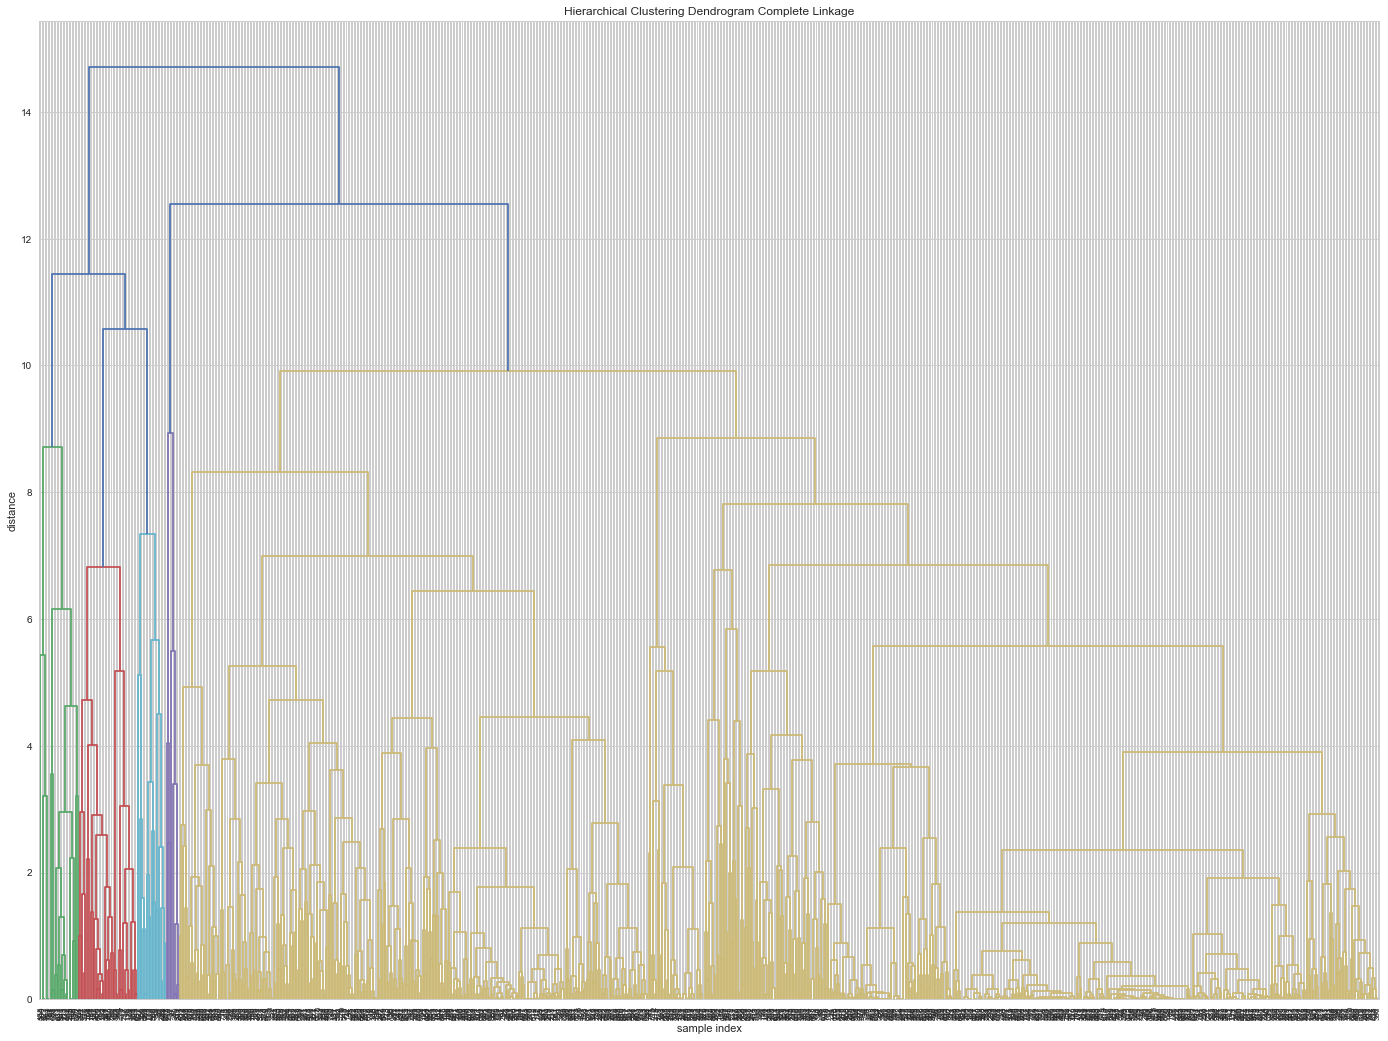

In [197]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

# Calculate the linkage
link = linkage(quantitative_data, method = "complete")

# Output the dendrogram
plt.figure(figsize = (24, 18))
plt.title("Hierarchical Clustering Dendrogram Complete Linkage")
plt.xlabel("sample index")
plt.ylabel("distance")
complete = dendrogram(link, leaf_rotation = 90., leaf_font_size = 8)
plt.show()

Plot the Complete Linkage Scree Plot:
----

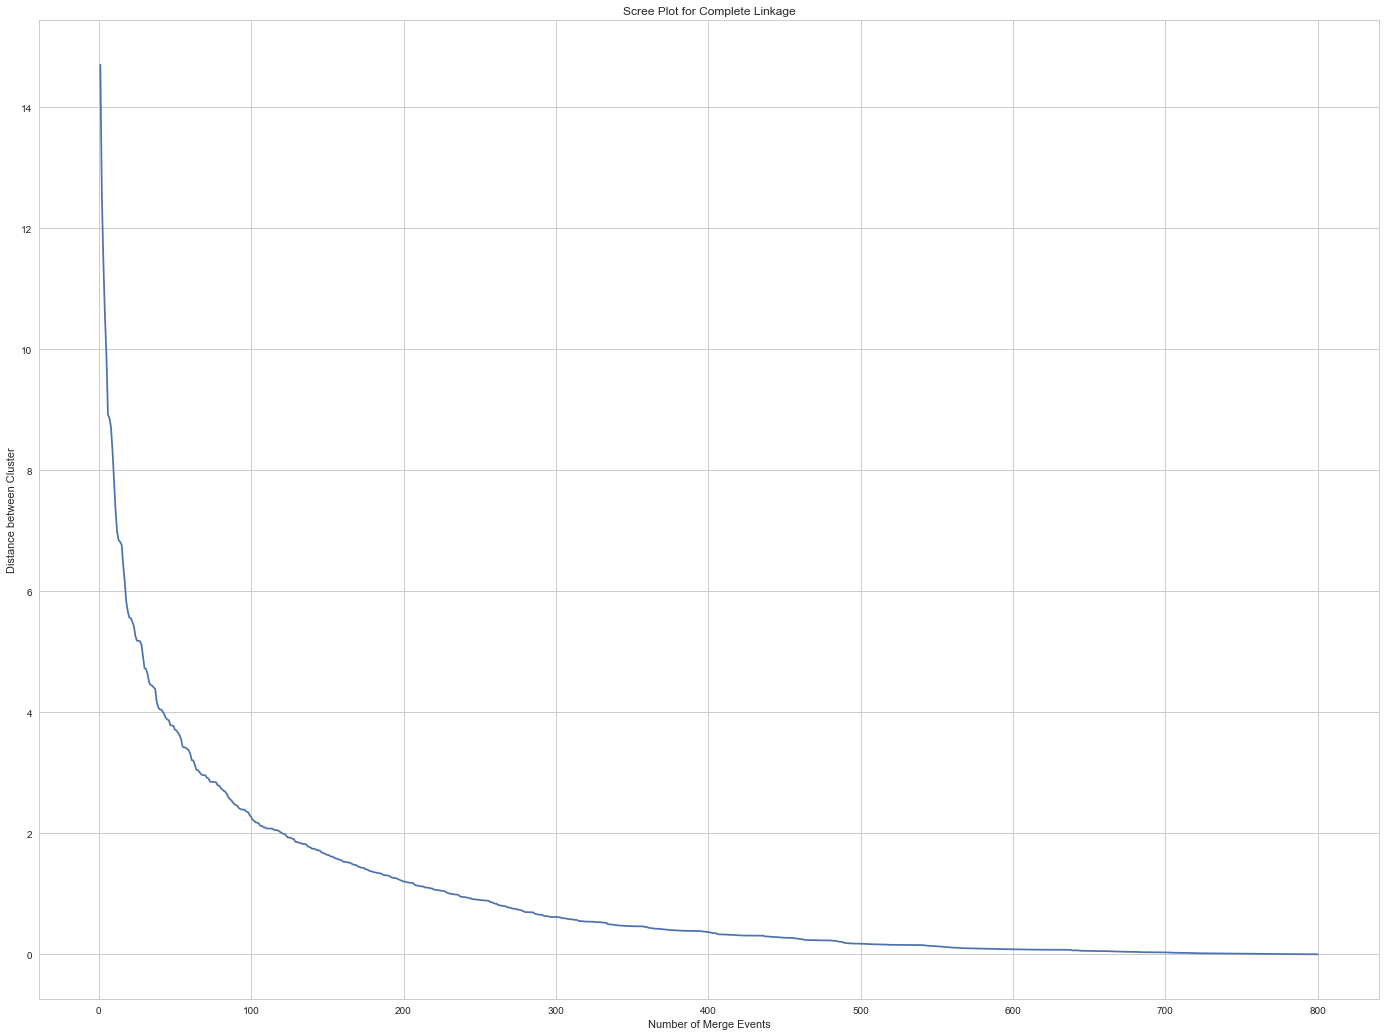

In [198]:
plt.figure(figsize = (24, 18))

last = link[-800:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last_rev) + 1)
plt.title("Scree Plot for Complete Linkage")
plt.xlabel("Number of Merge Events")
plt.ylabel("Distance between Cluster")
plt.plot(idxs, last_rev)

Let's explain the Dendrogram a little better:
----

In [208]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(linkage="complete",
                                n_clusters=25)
model = model.fit(quantitative_data)

cluster_labels = data["Survived"]
cluster_db = pd.DataFrame({'Survival'     : cluster_labels,
                           'Cluster'      : model.labels_},
                       columns=['Survival','Cluster'])
cluster_nd = cluster_db.values
cluster_db = cluster_db.groupby(["Cluster"])

cluster_db.describe()

Survival                                              
           count      mean       std  min   25%  50%  75%  max
Cluster                                                       
0           35.0  0.257143  0.443440  0.0  0.00  0.0  0.5  1.0
1           16.0  0.062500  0.250000  0.0  0.00  0.0  0.0  1.0
2           55.0  0.781818  0.416818  0.0  1.00  1.0  1.0  1.0
3           16.0  0.062500  0.250000  0.0  0.00  0.0  0.0  1.0
4           27.0  0.444444  0.506370  0.0  0.00  0.0  1.0  1.0
5            6.0  0.166667  0.408248  0.0  0.00  0.0  0.0  1.0
6           23.0  0.956522  0.208514  0.0  1.00  1.0  1.0  1.0
7           47.0  0.297872  0.462267  0.0  0.00  0.0  1.0  1.0
8            7.0  0.000000  0.000000  0.0  0.00  0.0  0.0  0.0
9           83.0  0.722892  0.450291  0.0  0.00  1.0  1.0  1.0
10           8.0  0.125000  0.353553  0.0  0.00  0.0  0.0  1.0
11          19.0  0.894737  0.315302  0.0  1.00  1.0  1.0  1.0
12         133.0  0.203008  0.403759  0.0  0.00  0.0  0.0  1.0
13           3.0  1.000000  0.000000  1.0  1.00  1.0  1.0  1.0
14          85.0  0.811765  0.393220  0.0  1.00  1.0  1.0  1.0
15          13.0  0.923077  0.277350  0.0  1.00  1.0  1.0  1.0
16         283.0  0.113074  0.317244  0.0  0.00  0.0  0.0  1.0
17           3.0  0.333333  0.577350  0.0  0.00  0.0  0.5  1.0
18           6.0  0.833333  0.408248  0.0  1.00  1.0  1.0  1.0
19           6.0  0.666667  0.516398  0.0  0.25  1.0  1.0  1.0
20           5.0  0.800000  0.447214  0.0  1.00  1.0  1.0  1.0
21           2.0  1.000000  0.000000  1.0  1.00  1.0  1.0  1.0
22           1.0  0.000000       NaN  0.0  0.00  0.0  0.0  0.0
23           1.0  0.000000       NaN  0.0  0.00  0.0  0.0  0.0
24           6.0  0.000000  0.000000  0.0  0.00  0.0  0.0  0.0

Let's carry out Principle Component Analysis
----

In [221]:
from sklearn.decomposition import PCA

pca = []

for x in range(12):
    pca.append(PCA(n_components=x))
    pca[x].fit(quantitative_data)

for x in range(len(pca[11].explained_variance_ratio_)):
    print("Principle Component [" + str(x + 1) + "] explains " 
          + str(pca[11].explained_variance_ratio_[x] * 100) 
          + " percent of the variance in the data.")

Principle Component [1] explains 28.4829618957 percent of the variance in the data.
Principle Component [2] explains 15.9392469831 percent of the variance in the data.
Principle Component [3] explains 11.2451042018 percent of the variance in the data.
Principle Component [4] explains 9.12911861915 percent of the variance in the data.
Principle Component [5] explains 8.16312758944 percent of the variance in the data.
Principle Component [6] explains 7.13091104344 percent of the variance in the data.
Principle Component [7] explains 6.3687104047 percent of the variance in the data.
Principle Component [8] explains 4.31379683659 percent of the variance in the data.
Principle Component [9] explains 4.00818829213 percent of the variance in the data.
Principle Component [10] explains 2.9993687834 percent of the variance in the data.
Principle Component [11] explains 2.21946535057 percent of the variance in the data.


In [222]:
for item in range(len(pca)):
    print("Components [" + str(item) + "]: " + str(sum(pca[item].explained_variance_ratio_)))

Components [0]: 0
Components [1]: 0.284829618957
Components [2]: 0.444222088787
Components [3]: 0.556673130806
Components [4]: 0.647964316997
Components [5]: 0.729595592892
Components [6]: 0.800904703326
Components [7]: 0.864591807373
Components [8]: 0.907729775739
Components [9]: 0.94781165866
Components [10]: 0.977805346494
Components [11]: 1.0


PCA Scree Plot
----

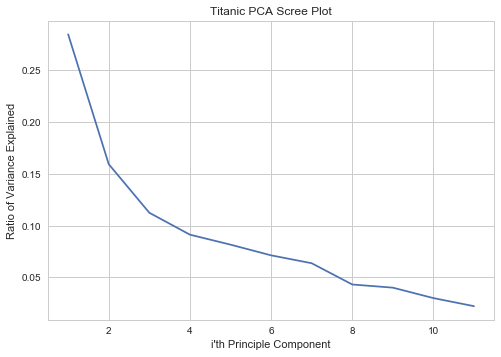

In [223]:
x = np.arange(1, 12, 1)
y = pca[11].explained_variance_ratio_

plt.title("Titanic PCA Scree Plot")
plt.ylabel("Ratio of Variance Explained")
plt.xlabel("i'th Principle Component")
plt.plot(x, y)

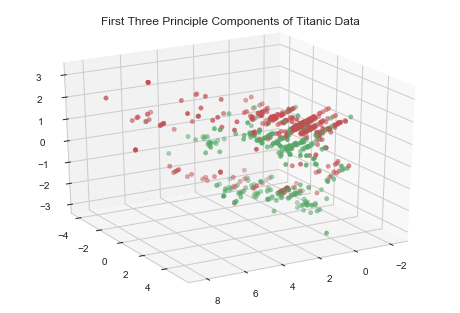

In [235]:
pca       = PCA(3)
projected = pca.fit_transform(quantitative_data) 

from mpl_toolkits import mplot3d

# Build color column
colors = []
for surv in data["Survived"]:
    if surv == 0:
        colors.append("r")
    if surv == 1:
        colors.append("g")

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(projected[:, 0], projected[:, 1], projected[:, 2], 
             c=colors, cmap=plt.cm.get_cmap('nipy_spectral', 10),
             depthshade = True)
ax.set_title("First Three Principle Components of Titanic Data")

ax.view_init(25, 60)

Build a Correlation Matrix
----

In [237]:
corr_mx = quantitative_data.corr()
corr_mx

,Ticket,Pclass,Age,Alone,Party Size,Fare,Miss,Mrs,Mr,Master,Important,SibSp,Parch
Ticket,1.000000,0.283840,-0.103426,0.036963,0.015486,-0.154941,-0.026707,-0.064078,0.073103,0.031169,-0.055763,0.046659,-0.032839
Pclass,0.283840,1.000000,-0.327954,0.138553,0.064221,-0.548193,0.002019,-0.146482,0.139156,0.081547,-0.207536,0.081656,0.016824
Age,-0.103426,-0.327954,1.000000,0.177712,-0.247546,0.088604,-0.249388,0.161039,0.191037,-0.377924,0.167427,-0.231875,-0.178232
Alone,0.036963,0.138553,0.177712,1.000000,-0.690654,-0.274079,-0.056641,-0.368924,0.399987,-0.266840,0.050232,-0.584186,-0.583112
Party Size,0.015486,0.064221,-0.247546,-0.690654,1.000000,0.218658,0.114070,0.158091,-0.340148,0.372350,-0.058811,0.890654,0.782988
Fare,-0.154941,-0.548193,0.088604,-0.274079,0.218658,1.000000,0.117078,0.103434,-0.181692,0.011390,0.024995,0.160887,0.217532
Miss,-0.026707,0.002019,-0.249388,-0.056641,0.114070,0.117078,1.000000,-0.203565,-0.596069,-0.109749,-0.089485,0.088945,0.106625
Mrs,-0.064078,-0.146482,0.161039,-0.368924,0.158091,0.103434,-0.203565,1.000000,-0.474629,-0.087389,-0.071254,0.064758,0.227819
Mr,0.073103,0.139156,0.191037,0.399987,-0.340148,-0.181692,-0.596069,-0.474629,1.000000,-0.255888,-0.208642,-0.252201,-0.335765
Master,0.031169,0.081547,-0.377924,-0.266840,0.372350,0.011390,-0.109749,-0.087389,-0.255888,1.000000,-0.038415,0.349434,0.267194


Derive Eigan Vector for PCA 1:
----

In [244]:
eig_vectors = np.linalg.eig(corr_mx)
for x in range(len(eig_vectors[0])):
    print(str(quantitative_data.columns.values[x]) + ": " + str(eig_vectors[0][x]))

Ticket: 3.70278504644
Pclass: 2.0721021078
Age: 1.46186354624
Alone: 1.18678542049
Party Size: 1.06120658663
Fare: 0.927018435648
Miss: 0.827932352611
Mrs: 0.288530495574
Mr: 0.389917941841
Master: 0.560793588757
Important: 0.521064477977
SibSp: -4.627993311e-16
Parch: 1.9175311375e-15


Find the highest 5 absolute values on PC1:
----

In [254]:
raw_score  = quantitative_data * eig_vectors[0]
sum_       = np.array(np.abs(np.sum(raw_score,axis=1).tolist()))
x          = np.arange(0, len(sum_), 1).astype(int)

sum_tuples = np.column_stack((sum_, x))
sorted_t   = sorted(sum_tuples, key=lambda tup: tup[0])

highest    = sorted_t[-5:]
for x in highest:
    print("Principle Component 1 Score: " + str(x[0]) + " Location in DataFrame: " + str(int(x[1])) + "\n")
    print("Before PCA[0]:")
    print(quantitative_data.loc[int(x[1])])
    print("")
    print("After PCA[0]:")
    print(quantitative_data.loc[int(x[1])] * eig_vectors[0])
    print("")
    print("Survival :" + str(data["Survived"][int(x[1])]))
    print("-----------------------------------------------------------")
    print("")

Principle Component 1 Score: 18.0726663117 Location in DataFrame: 527

Before PCA[0]:
Ticket        4.269350
Pclass        0.825209
Age           0.721125
Alone         0.813439
Party Size   -0.561804
Fare         -0.486650
Miss         -0.505618
Mrs          -0.402606
Mr            0.848255
Master       -0.217058
Important    -0.176982
SibSp        -0.475199
Parch        -0.474326
Name: 527, dtype: float64

After PCA[0]:
Ticket        1.580849e+01
Pclass        1.709917e+00
Age           1.054187e+00
Alone         9.653770e-01
Party Size   -5.961905e-01
Fare         -4.511335e-01
Miss         -4.186176e-01
Mrs          -1.161641e-01
Mr            3.307497e-01
Master       -1.217248e-01
Important    -9.221885e-02
SibSp         2.199218e-16
Parch        -9.095346e-16
Name: 527, dtype: float64

Survival :0
-----------------------------------------------------------

Principle Component 1 Score: 18.2831776175 Location in DataFrame: 760

Before PCA[0]:
Ticket        4.269314
Pclass        